In [1]:
import pandas as pd
import numpy as np


In [2]:
# Import the Dataset 
file_path = 'Power_outage_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully!")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path.")
    exit()


Dataset imported successfully!


In [3]:
df.columns

Index(['Event Description', 'Year', 'Date Event Began', 'Time Event Began',
       'Date of Restoration', 'Time of Restoration', 'Respondent',
       'Geographic Areas', 'NERC Region', 'Demand Loss (MW)',
       'Number of Customers Affected', 'Tags'],
      dtype='object')

In [4]:
import pandas as pd

print("\nInitial Dataset Info")
print(df.info())
print("\nFirst 5 rows of the dataset:")
print(df.head(30))

# Standardize column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_')
              .str.replace('(', '', regex=False)
              .str.replace(')', '', regex=False)
)

print("\nStandardized columns:")
print(df.columns)

try:
    # Correct datetime parsing format: m/d/Y and 12-hour clock with AM/PM
    df['start_datetime'] = pd.to_datetime(
        df['date_event_began'] + ' ' + df['time_event_began'],
        format='%m/%d/%Y %I:%M %p',
        errors='coerce'
    )

    df['end_datetime'] = pd.to_datetime(
        df['date_of_restoration'] + ' ' + df['time_of_restoration'],
        format='%m/%d/%Y %I:%M %p',
        errors='coerce'
    )

    # Drop the original separate columns
    df = df.drop(columns=[
        'date_event_began',
        'time_event_began',
        'date_of_restoration',
        'time_of_restoration'
    ])

    print("\nDates combined and converted to datetime objects.")
    print(df[['start_datetime', 'end_datetime']].head())

except KeyError as e:
    print(f"Error: One of the expected date/time columns was not found: {e}")
    exit()
except Exception as e:
    print(f"Unexpected error during datetime conversion: {e}")
    exit()

# Filter only rows where end > start
before = len(df)
df = df[df['end_datetime'] > df['start_datetime']].copy()
after = len(df)
print(f"\nRows before filtering: {before}, after filtering: {after}")

# Calculate outage duration in minutes
df['outage_duration_minutes'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 60
print("\n'outage_duration_minutes' column created.")
print(df['outage_duration_minutes'].describe())

# Handle missing values in numeric columns
df['number_of_customers_affected'] = pd.to_numeric(
    df['number_of_customers_affected'].str.replace(',', '').replace('Unknown', '0'),
    errors='coerce'
).fillna(0)

print("\nFilled missing values in 'number_of_customers_affected' with 0.")

# Save cleaned dataset
df.to_csv('cleaned_power_outage_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_power_outage_data.csv'.")
print("\n--- Preprocessing Complete ---")
print(f"Final dataset shape: {df.shape}")



Initial Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Event Description             1652 non-null   object
 1   Year                          1652 non-null   int64 
 2   Date Event Began              1652 non-null   object
 3   Time Event Began              1643 non-null   object
 4   Date of Restoration           1638 non-null   object
 5   Time of Restoration           1632 non-null   object
 6   Respondent                    1652 non-null   object
 7   Geographic Areas              1651 non-null   object
 8   NERC Region                   1650 non-null   object
 9   Demand Loss (MW)              1246 non-null   object
 10  Number of Customers Affected  1434 non-null   object
 11  Tags                          1651 non-null   object
dtypes: int64(1), object(11)
memory usage: 155.0+ KB
None



In [5]:
data = pd.read_csv('cleaned_power_outage_data.csv')
data.columns

Index(['event_description', 'year', 'respondent', 'geographic_areas',
       'nerc_region', 'demand_loss_mw', 'number_of_customers_affected', 'tags',
       'start_datetime', 'end_datetime', 'outage_duration_minutes'],
      dtype='object')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('cleaned_power_outage_data.csv', parse_dates=['start_datetime','end_datetime'])
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   event_description             729 non-null    object        
 1   year                          729 non-null    int64         
 2   respondent                    729 non-null    object        
 3   geographic_areas              729 non-null    object        
 4   nerc_region                   729 non-null    object        
 5   demand_loss_mw                580 non-null    object        
 6   number_of_customers_affected  729 non-null    float64       
 7   tags                          729 non-null    object        
 8   start_datetime                729 non-null    datetime64[ns]
 9   end_datetime                  729 non-null    datetime64[ns]
 10  outage_duration_minutes       729 non-null    float64       
dtypes: datetime64[ns](2), float64(2)

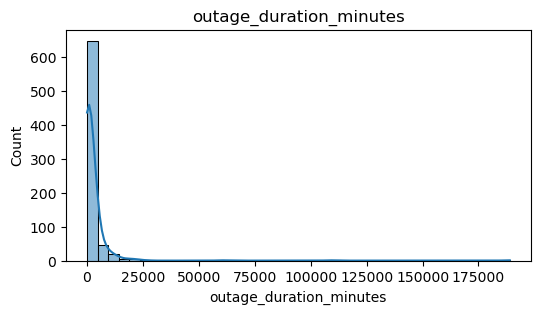

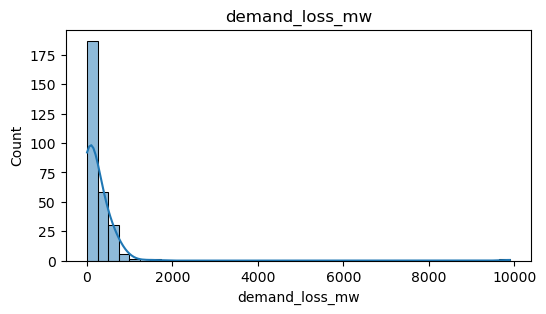

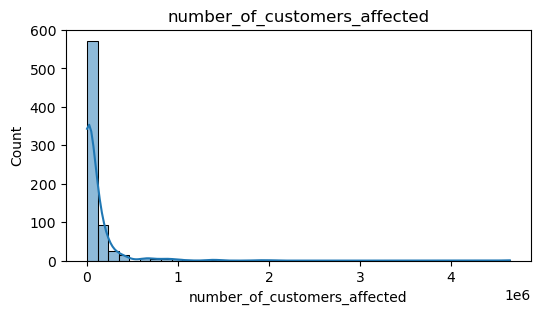

respondent 289


respondent
PacifiCorp                        35
ISO New England                   31
Delmarva Power & Light Company    26
Southern Company                  17
City of Tacoma (TPWR)             16
Tacoma Power (TPWR)               16
Tennessee Valley Authority        16
Pacific Gas & Electric Co         15
American Electric Power           14
Exelon Corporation/ComEd          14
Name: count, dtype: int64

geographic_areas 480


geographic_areas
Texas                 16
Tacoma, Washington    11
California             9
Pennsylvania           9
Illinois               9
Alberta, Canada        9
Maryland               8
Newark, Delaware       7
Michigan               7
Unknown                7
Name: count, dtype: int64

nerc_region 14


nerc_region
RFC      210
WECC     192
SERC     121
NPCC      81
SPP       36
TRE       34
MRO       27
PR        12
FRCC       7
ERCOT      2
Name: count, dtype: int64

tags 44


tags
vandalism, physical                         172
severe weather                              102
severe weather, thunderstorm                 89
vandalism                                    83
severe weather, winter storm                 51
public appeal                                26
severe weather, hurricane/tropical storm     26
islanding                                    25
load shedding                                24
severe weather, cold                         23
Name: count, dtype: int64

In [7]:
#Univariate analysis Numeric distributions
num_cols = ['outage_duration_minutes','demand_loss_mw','number_of_customers_affected']
df['demand_loss_mw'] = pd.to_numeric(df['demand_loss_mw'], errors='coerce')
df['number_of_customers_affected'] = pd.to_numeric(df['number_of_customers_affected'], errors='coerce')

for c in ['outage_duration_minutes','demand_loss_mw','number_of_customers_affected']:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(df[c].dropna(), bins=40, kde=True)
        plt.title(c)
        plt.show()

cat_cols = ['respondent','geographic_areas','nerc_region','tags']
for c in cat_cols:
    if c in df.columns:
        print(c, df[c].nunique())
        display(df[c].value_counts().head(10))

In [8]:
print(df[['nerc_region','respondent','geographic_areas','outage_duration_minutes']].head())
print(df[['nerc_region','respondent','geographic_areas']].nunique())
print(df['outage_duration_minutes'].describe())


  nerc_region                               respondent       geographic_areas  \
0         RFC                 Exelon Corporation/ComEd               Illinois   
1         RFC  Northern Indiana Public Service Company  North Central Indiana   
2         MRO                              We Energies   Southeast  Wisconsin   
3        SERC               Tennessee Valley Authority   Nashville, Tennessee   
4        SERC               Tennessee Valley Authority   Nashville, Tennessee   

   outage_duration_minutes  
0                   2790.0  
1                   1060.0  
2                    538.0  
3                      1.0  
4                      1.0  
nerc_region          14
respondent          289
geographic_areas    480
dtype: int64
count       729.000000
mean       2455.434842
std        8915.604166
min           1.000000
25%          77.000000
50%         540.000000
75%        2670.000000
max      188978.000000
Name: outage_duration_minutes, dtype: float64


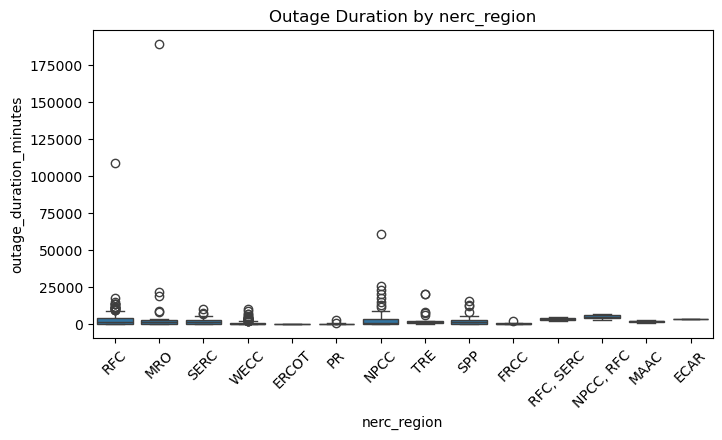

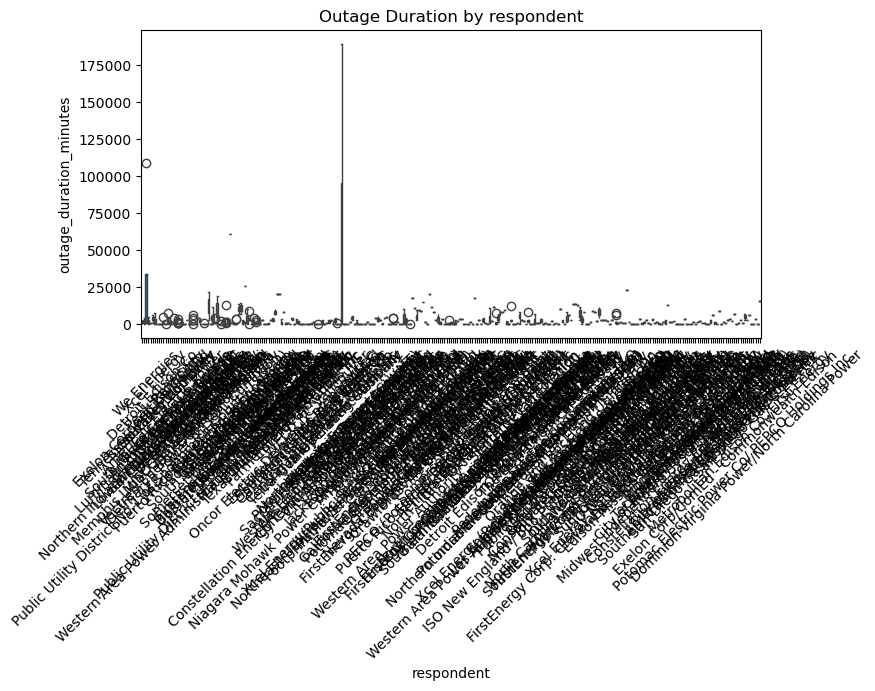

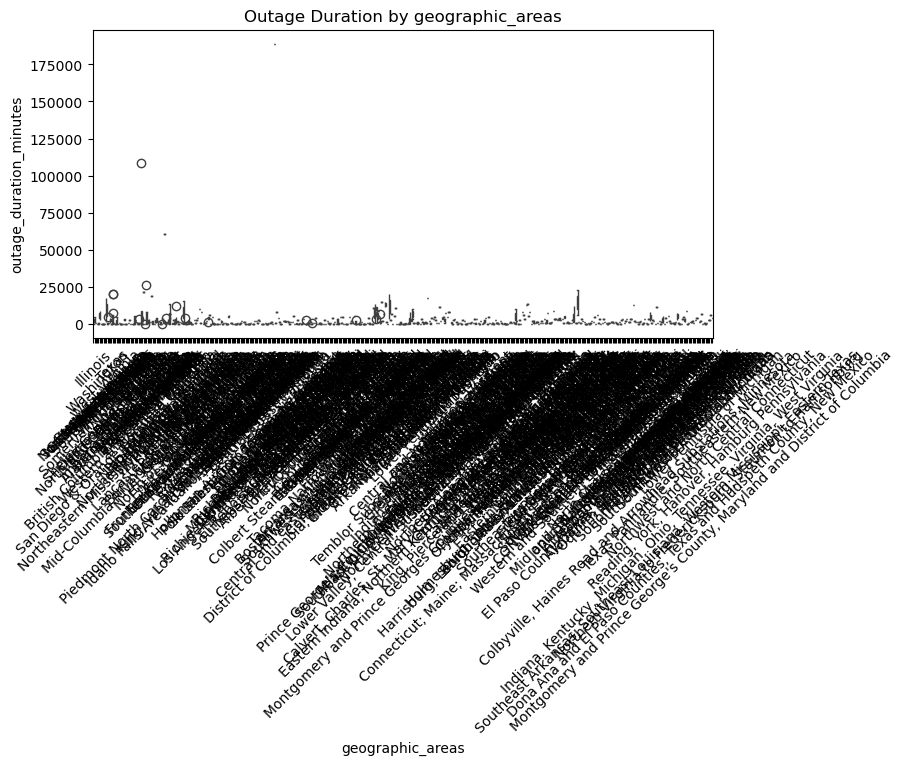

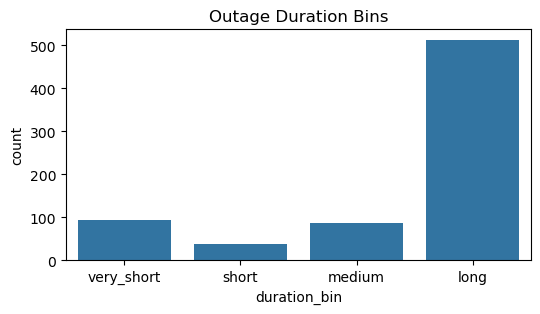

In [9]:
# Bivariate analysis
# Outage duration by categorical variable 
for c in ['nerc_region','respondent','geographic_areas']:
    if c in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=c, y='outage_duration_minutes', data=df)
        plt.xticks(rotation=45)
        plt.title(f'Outage Duration by {c}')
        plt.show()

df['duration_bin'] = pd.cut(df['outage_duration_minutes'],
                           bins=[-1,5,30,120,1e9],
                           labels=['very_short','short','medium','long'])
plt.figure(figsize=(6,3))
sns.countplot(x='duration_bin', data=df, order=['very_short','short','medium','long'])
plt.title('Outage Duration Bins')
plt.show()

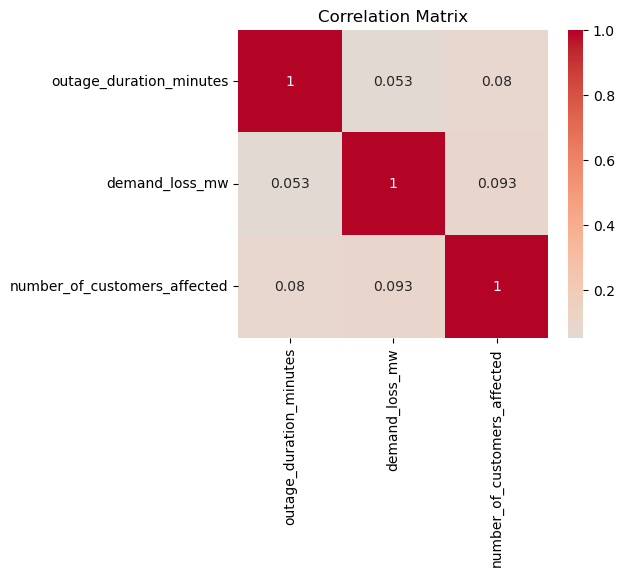

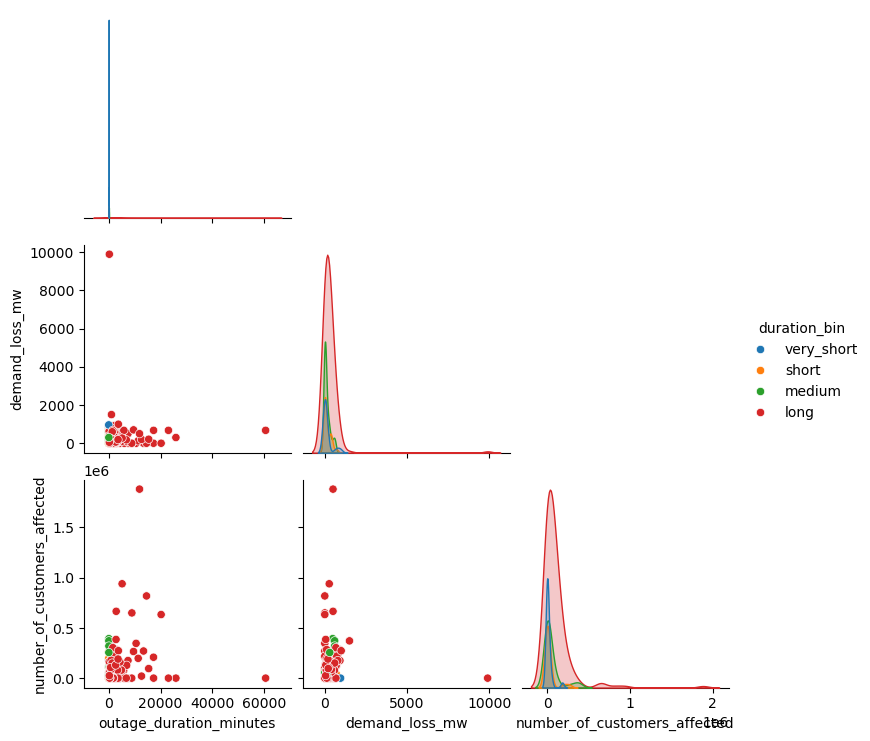

In [10]:
#Correlation & pairplot
num_for_corr = ['outage_duration_minutes','demand_loss_mw','number_of_customers_affected']
num_for_corr = [c for c in num_for_corr if c in df.columns]
plt.figure(figsize=(5,4))
sns.heatmap(df[num_for_corr].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Pairplot

sns.pairplot(df[num_for_corr + ['duration_bin']].dropna(), hue='duration_bin', corner=True)
plt.show()

In [11]:
#Time-based features
df['start_hour'] = df['start_datetime'].dt.hour
df['start_weekday'] = df['start_datetime'].dt.weekday
df['is_weekend'] = df['start_weekday'].isin([5,6]).astype(int)
df['start_month'] = df['start_datetime'].dt.month

# Text / boolean features
df['event_desc_len'] = df['event_description'].fillna('').str.len()
df['has_tags'] = df['tags'].notna().astype(int)

In [12]:
# Target and candidate features
df['target_long'] = (df['outage_duration_minutes'] > 60).astype(int)

# Candidate features
numeric_features = [
    'demand_loss_mw','number_of_customers_affected','event_desc_len',
    'start_hour','start_weekday','start_month','is_weekend'
]
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = [c for c in ['respondent','geographic_areas','nerc_region'] if c in df.columns]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['demand_loss_mw', 'number_of_customers_affected', 'event_desc_len', 'start_hour', 'start_weekday', 'start_month', 'is_weekend']
Categorical: ['respondent', 'geographic_areas', 'nerc_region']


In [13]:
#Preprocessing
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)],
    remainder='drop')

In [14]:
#Train/test split
df = df.dropna(subset=['target_long'])
X = df[numeric_features + categorical_features]
y = df['target_long']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.value_counts(normalize=True))

(583, 10) (146, 10) target_long
1    0.768439
0    0.231561
Name: proportion, dtype: float64


In [15]:
#Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

K = 10

pipe_select = Pipeline([
    ('preproc', preproc),                       # ColumnTransformer from Step 8
    ('select', SelectKBest(score_func=f_classif, k=K))
])

pipe_select.fit(X_train, y_train)

num_feat_names = numeric_features
if categorical_features:
    ohe = pipe_select.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
    cat_imputer = pipe_select.named_steps['preproc'].named_transformers_['cat'].named_steps['imputer']
    cat_names = []
    for i, col in enumerate(categorical_features):
        cats = ohe.categories_[i]
        cat_names += [f"{col}__{str(c)}" for c in cats]
else:
    cat_names = []

all_feat_names = num_feat_names + cat_names

selected_idx = pipe_select.named_steps['select'].get_support(indices=True)
selected_features = [all_feat_names[i] for i in selected_idx]

print("Selected top features (K={}):".format(K))
for i, f in enumerate(selected_features, 1):
    print(f"{i}. {f}")

Selected top features (K=10):
1. number_of_customers_affected
2. respondent__Delmarva Power & Light Company
3. respondent__PacifiCorp
4. respondent__Potomac Electric Power Company (PEPCO)
5. geographic_areas__Alberta, Canada
6. geographic_areas__Salt Lake City, Utah
7. geographic_areas__Utah
8. geographic_areas__Vermont
9. geographic_areas__Wilmington, Delaware
10. nerc_region__WECC


In [16]:
# Final Model Training and Evaluation  

# Split data into features and target  
X = df[numeric_features + categorical_features]  
y = df['target_long']  

# Split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  

# Final Model Pipeline with Feature Selection  
final_model = Pipeline([  
    ('preproc', preproc),  # Our preprocessing pipeline  
    ('select', SelectKBest(score_func=f_classif, k=K)),  # Feature selection  
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))  
])  

# Train the model  
print("\nTraining the model...")  
final_model.fit(X_train, y_train)  

# Make predictions  
y_pred = final_model.predict(X_test)  
y_pred_proba = final_model.predict_proba(X_test)[:, 1] 


Training the model...



Model Evaluation:
Accuracy: 0.63
Precision: 0.93
Recall: 0.56
F1 Score: 0.70
ROC AUC: 0.78


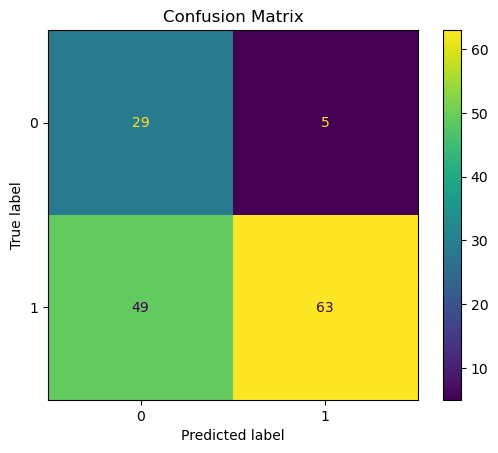


Top 5 Features:
- demand_loss_mw: 0.750
- number_of_customers_affected: 0.085
- respondent_AES Somerset LLC: 0.037
- event_desc_len: 0.035
- start_hour: 0.033


In [17]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# key metrics
print("\nModel Evaluation:")
print("="*40)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

if hasattr(final_model.named_steps['classifier'], 'feature_importances_'):
    importances = final_model.named_steps['classifier'].feature_importances_
    feature_names = numeric_features + list(
        final_model.named_steps['preproc']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
    )
    
    top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:5]
    print("\nTop 5 Features:")
    for feat, imp in top_features:
        print(f"- {feat}: {imp:.3f}")

In [18]:
#sample new outage record
new_data = pd.DataFrame({
    'demand_loss_mw': [150.5],                   # Numeric: MW of demand lost
    'number_of_customers_affected': [5000],      # Numeric: Customers affected
    'event_desc_len': [120],                     # Numeric: Description length
    'start_hour': [14],                          # Numeric: Hour of day (2 PM)
    'start_weekday': [2],                        # Numeric: Tuesday (0=Mon, 6=Sun)
    'start_month': [7],                          # Numeric: July
    'is_weekend': [0],                           # Binary: Not weekend
    'respondent': ['Utility Company A'],         # Categorical: Utility provider
    'geographic_areas': ['Northeast'],           # Categorical: Region
    'nerc_region': ['RFC']                       # Categorical: NERC region
})

# prediction
prediction = final_model.predict(new_data)
prediction_proba = final_model.predict_proba(new_data)

print("\nPrediction Results:")
print("="*40)
print(f"Will this be a long outage (>60 min)? {'YES' if prediction[0] else 'NO'}")
print(f"Probability of long outage: {prediction_proba[0][1]:.2%}")
print(f"Probability of short outage: {prediction_proba[0][0]:.2%}")


Prediction Results:
Will this be a long outage (>60 min)? YES
Probability of long outage: 94.00%
Probability of short outage: 6.00%
